In [51]:
import librosa, librosa.display
import numpy as np
from pydub import AudioSegment
import my_utils
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch

n_fft = 1024
hop_length = 8
sr = 16000

# cate bucati PF iau in considerare pentru AF -> cu overlapping => 15 frame-uri 
# ultimul frame din AF fiind PF-ul curent
nb_of_PFs_per_AF = 8

In [52]:
def get_STFT_AF_frames(AF_array, PF_size):
    frames = []
    half = (int)(PF_size/2)
    
    for i in range (0, AF_array.shape[0]):

        # 1. add current frame from AF
        frame = librosa.stft(librosa.to_mono(AF_array[i]), window='hann', n_fft=n_fft, hop_length=hop_length)
        frame = np.abs(frame)
        
        tensor = []
        tensor.append(frame)        
        frames.append(tensor)
        
        # 2. add overlapped frame if the current frame is not the last one
        if i < AF_array.shape[0]-1:
            overlap_frame = AF_array[i][half:]
            overlap_frame = np.concatenate((overlap_frame, AF_array[i+1][:half]))
            
            frame = librosa.stft(librosa.to_mono(overlap_frame), window='hann', n_fft=n_fft, hop_length=hop_length)
            frame = np.abs(frame)

            tensor = []
            tensor.append(frame)
            frames.append(tensor)
        
    
    return np.asarray(frames)

In [53]:
def get_train_set_for_mix(mix, voice_1, voice_2, samples_per_frame):
    inputs = []
    targets = []
    
    mix_frames = np.array([mix[i:i + samples_per_frame] for i in range(0, len(mix), samples_per_frame)])
    voice_1_frames = np.array([voice_1[i:i + samples_per_frame] for i in range(0, len(mix), samples_per_frame)])
    voice_2_frames = np.array([voice_2[i:i + samples_per_frame] for i in range(0, len(mix), samples_per_frame)])
    
    for index in range(mix_frames.shape[0]):
        
        if index < nb_of_PFs_per_AF - 1:
            continue
        
        # 1. create train set input for AF with current PF and previous frames
        AF_frames = np.array([mix_frames[i] for i in range(index - nb_of_PFs_per_AF, index)])
        AF_STFT_frames = get_STFT_AF_frames(AF_array=AF_frames, PF_size= samples_per_frame)
        inputs.append(AF_STFT_frames)
        
        # 2. create train set target for that AF, containing the mask for the current PF
        stft_voice_1 = librosa.stft(librosa.to_mono(voice_1_frames[index]), window='hann', n_fft=n_fft, hop_length=hop_length)
        stft_voice_2 = librosa.stft(librosa.to_mono(voice_2_frames[index]), window='hann', n_fft=n_fft, hop_length=hop_length)
        mask = my_utils.compute_mask(stft_voice_1, stft_voice_2)
        
        targets.append(mask)
    
    # train set for only one audio
    train_set_input = torch.from_numpy(np.array(inputs))
    
    # target contains the calculated masks for each PF from mix
    train_set_target = torch.from_numpy(np.array(targets))

#     assert(train_set_input.shape == (996, 4, 1, 513, 11))
#     assert(train_set_target.shape == (996, 513, 11))
    train_set = dict(zip(train_set_input, train_set_target))
    return train_set
    

In [54]:
class Network(nn.Module):
    height = 0
    width = 0
    
    # default values for height and width are given for a processing frame of 5 ms
    def __init__(self, height = 513, width = 11):
        super(Network, self).__init__()
        self.height = height
        self.width = width
        
        # layer 1
        self.fc1 = nn.Linear(1 * height * width, 250)
        self.fc1_batch = nn.BatchNorm1d(250)
        
        # layer 2
        self.fc2 = nn.Linear(250, 250)
        self.fc2_batch = nn.BatchNorm1d(250)
        
        # layer 3
        self.fc3 = nn.Linear(250, height * width)
        self.fc3_batch = nn.BatchNorm1d(height * width)

    def forward(self, x):
        
        # layer 1
        # firstly, transform the matrix into an array for the FC
        x = x.view(-1, self.height * self.width)        
        x = self.fc1(x)
        x = torch.sigmoid(x)
        x = self.fc1_batch(x)
#         print("1 shapes: ", x.shape)
        
        # layer 2
        x = self.fc2(x)
        x = torch.sigmoid(x)
        x = self.fc2_batch(x)
#         print("2 shapes: ", x.shape)
        
        # layer 3
        x = self.fc3(x)
        x = torch.sigmoid(x)
        x = self.fc3_batch(x)
#         print("3 shapes: ", x.shape)
        
        return x

In [55]:
# create network
# no params => height = 513, width = 11 -> for a processing frame of 5 ms
network = Network()

# if cuda is available, send network's params to gpu
if torch.cuda.is_available():
    print("network sent to CUDA")
    network.cuda()
    
# set optimizer -> article : Adam, lr = 0.001, b1 = 0.9, b2 = 0.999
optimizer = optim.Adam(network.parameters(), lr = 0.001, betas = (0.9, 0.999))
loss_function = nn.MSELoss()

network sent to CUDA


In [56]:
# init arrays for train/test errors
train_losses = []
train_counter = []

test_losses = []
test_counter = [i*len(train_set) for i in range(n_epochs)]

In [68]:
male_filename = 'recordings/voice2/arctic_a0002.wav'
female_filename = 'recordings/voice1/arctic_a0001.wav'

male, sr = librosa.load(male_filename, sr=16000) 
female, sr = librosa.load(female_filename, sr=16000) 

# pad smaller array with zeros, so both audio files have the same length
female, male = my_utils.make_wav_files_same_size(female, male)

# load the mixed audio 
mix = female + male

male = np.array(male)
female = np.array(female)
mix = np.array(mix)

frame_length_ms = 5
mix_length_ms = len(mix) / sr * 1000
samples_per_frame = (int)(len(mix) * frame_length_ms / mix_length_ms)

print("mix total length: ",len(mix))
print("mix total length (ms) : ", mix_length_ms)
print("nb of samples for", frame_length_ms,"ms frame =", samples_per_frame, "samples/array")
print("---------------------------------------------------------")


train_set = get_train_set_for_mix(mix, female, male, samples_per_frame)

# make test set the same as train set so I can test the overfitting
test_set = get_train_set_for_mix(mix, female, male, samples_per_frame) 
print("AF entries in train_set: ",len(train_set))

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\Lenovo\\Desktop\\sound-source-separation\\recordings\\voice2\\arctic_a0002.wav'

In [61]:
def train_network(nr_epochs, train_set, test_set):

    mask = []
    mask_test = []

    last_valid_loss = 0
    nb_of_epochs_for_valid_loss = 0

    # plot train/valid loss contains losses on each epoch, so we can see after each epoch what happens with the error
    plot_train_loss = []
    plot_valid_loss = []

    for epoch in range(1, 50):
        mask = []
        mask_test = []

        train_loss, valid_loss = [], []
        loss = 0

        print("--------------------------------------Epoch", str(epoch) ,"------------------------------")
        ## training part 
        network.train()
        for index, (input, target) in enumerate(train_set.items()):

            # target is transformed from a matrix to an array, so the error can be calculated easier
            # since the network returns an array
            target_view = target.view(-1, target.shape[0] * target.shape[1])

            # if cuda is available, send (input, target) to gpu
            if torch.cuda.is_available():
                input, target_view = input.cuda(), target_view.cuda()

            optimizer.zero_grad()

            # 1. forward propagation
            output = network(input)


            # 2. loss calculation
            loss = loss_function(target_view[0], output[len(output)-1])  


            # 3. backward propagation
            loss.backward() 


            # 4. weight optimization
            optimizer.step()


            # 5. save the loss for this PF
            train_loss.append(loss.item())


            # 6. save the mask for the current PF, meaning the last entry in the output[AF]
            current_mask = output[len(output)-1].view(513, 11)
            mask.append(current_mask)

        # add the mean loss for this training epoch for ploting
        plot_train_loss.append(np.mean(train_loss))

        #-----------------------------------------------------------------------
        ## evaluation part 
        network.eval()
        for index, (input, target) in enumerate(test_set.items()):

            # if cuda is available, send (input, target) to gpu
            target_view = target.view(-1, target.shape[0] * target.shape[1])
            if torch.cuda.is_available():
                input, target_view = input.cuda(), target_view.cuda()

            # 1. forward propagation
            output = network(input)

            # 2. loss calculation
            loss = loss_function(target_view[0], output[len(output)-1]).detach().item()

            # 6. save the mask for the current PF, meaning the last entry in the output
            current_mask = output[len(output)-1].view(513, 11)
            mask_test.append(current_mask)

            if loss != last_valid_loss:
                last_valid_loss = loss
            else:
                nb_of_epochs_for_valid_loss += 1

            valid_loss.append(loss)

        # add the mean loss for this training epoch for ploting
        plot_valid_loss.append(np.mean(valid_loss))

        # check if we have the same loss for validation set
        if last_valid_loss == (np.mean(valid_loss)):
            nb_of_epochs_for_valid_loss += 1
        else:
            last_valid_loss = np.mean(valid_loss)

        print ("\nTraining Loss: ", np.mean(train_loss), "\nValid Loss: ", np.mean(valid_loss))
        
        if(nb_of_epochs_for_valid_loss == 20):
            break


    plt.plot(plot_train_loss)
    plt.title('train losses')
    plt.show()

    plt.plot(plot_valid_loss)
    plt.title('valid losses')
    plt.show()
    
    return mask, mask_test


--------------------------------------Epoch 1 ------------------------------

Training Loss:  0.09602044316164669 
Valid Loss:  0.24113926033077673
--------------------------------------Epoch 2 ------------------------------

Training Loss:  0.10151279514409803 
Valid Loss:  0.22516967629177229
--------------------------------------Epoch 3 ------------------------------

Training Loss:  0.09364302474767033 
Valid Loss:  0.23006243946960184
--------------------------------------Epoch 4 ------------------------------

Training Loss:  0.09183143370821441 
Valid Loss:  0.2370712786611856
--------------------------------------Epoch 5 ------------------------------

Training Loss:  0.08927079544826966 
Valid Loss:  0.2557626906744873
--------------------------------------Epoch 6 ------------------------------

Training Loss:  0.09198182895476847 
Valid Loss:  0.30842207001336014
--------------------------------------Epoch 7 ------------------------------

Training Loss:  0.08692075703881609 

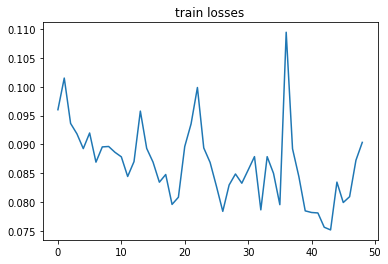

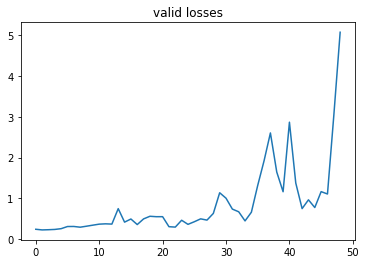

993
torch.Size([513, 11])
993
torch.Size([513, 11])


In [64]:
mask, mask_test = train_network(nr_epochs=50 , train_set=train_set, test_set=test_set)

print(len(mask))
print(mask[0].shape)

print(len(mask_test))
print(mask_test[0].shape)


Validation set loss: 5.07331905525491


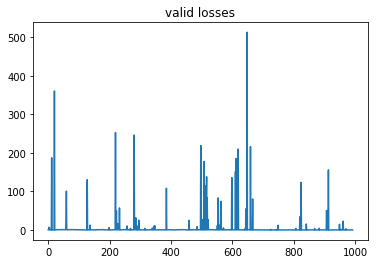

In [65]:
network.eval()

valid_loss, valid_mask = [], []

for index, (input, target) in enumerate(test_set.items()):
    
    target_view = target.view(-1, target.shape[0] * target.shape[1])
    
    # if cuda is available, send (input, target) to gpu
    if torch.cuda.is_available():
        input, target_view = input.cuda(), target_view.cuda()
    
    # 1. forward propagation
    output = network(input)
    
    # 2. loss calculation
    loss = loss_function(target_view[0], output[len(output)-1]).detach().item()
    
    # 3. save the mask for the current PF, meaning the last entry in the output
    current_mask = output[len(output)-1].view(513, 11)
    valid_mask.append(current_mask)
    
    valid_loss.append(loss)
    
    
print("Validation set loss:", np.mean(valid_loss))

plt.plot(valid_loss)
plt.title('valid losses')
plt.show()  


In [66]:
# apply generate mask from training, testing after training and validation 
split_audios_epoch(1, mask)
split_audios_epoch(2, mask_test)
split_audios_epoch(3, valid_mask)

In [42]:
# RECONSTRUIRE SUNET PE FRAME-URI, FOLOSIND TARGETURILE GENERATE PT SETUL DE ANTRENARE
def split_audios_epoch(epoch, mask):
    mask_stack = torch.stack(mask)
#     print(mask_stack.shape)

    cpu_mask = mask_stack.cpu()
#     print(cpu_mask.shape)

    n_mask = cpu_mask.detach().numpy()
#     print(n_mask.shape)

    mix_frames = np.array([mix[i:i + samples_per_frame] for i in range(0, len(mix), samples_per_frame)])
    sound1 = np.empty([0,])
    sound2 = np.empty([0,])


    for i in range (0, len(mix_frames)):
        stft_mix = librosa.stft(librosa.to_mono(mix_frames[i]), window='hann', n_fft=n_fft, hop_length=hop_length)
        

        # reteaua nu a invatat mastile pentru primele 7(n) bucati [PF] din mix
        # deci las matricea STFT asa cum e in mix
        if i < nb_of_PFs_per_AF - 1:)
            y_frame_1_stft_with_mask = stft_mix
            y_frame_2_stft_with_mask = stft_mix

            inverse_sound1_stft = librosa.istft(y_frame_1_stft_with_mask, hop_length=hop_length, window='hann')
            inverse_sound2_stft = librosa.istft(y_frame_2_stft_with_mask, hop_length=hop_length, window='hann')

            sound1 = np.concatenate((sound1, inverse_sound1_stft))
            sound2 = np.concatenate((sound2, inverse_sound2_stft))
            
        else:
            # n_mask[i-7] pentru ca reteaua invata pt AF-uri facute pe cate 8 PF-uri -> 15 items pt AF
            # abia de cand ajunge la primul AF care s a putut compune, folosesc masca invata de retea
            
            y_frame_1_stft_with_mask = np.multiply(n_mask[i-7], stft_mix)
            y_frame_2_stft_with_mask = np.multiply((1 -  n_mask[i-7]), stft_mix)

            inverse_sound1_stft = librosa.istft(y_frame_1_stft_with_mask, hop_length=hop_length, window='hann')
            inverse_sound2_stft = librosa.istft(y_frame_2_stft_with_mask, hop_length=hop_length, window='hann')

            sound1 = np.concatenate((sound1, inverse_sound1_stft))
            sound2 = np.concatenate((sound2, inverse_sound2_stft))


    librosa.output.write_wav("recordings/CNN-rec_frames-1-"+ str(epoch) + ".wav", sound1, sr = 16000)
    librosa.output.write_wav("recordings/CNN-rec_frames-2-"+ str(epoch) + ".wav", sound2, sr = 16000)

input and target sent to CUDA
Train Epoch: 1 [0/997 (0%)]	Loss: 0.045482
Train Epoch: 1 [10/997 (1%)]	Loss: 0.040284
Train Epoch: 1 [20/997 (2%)]	Loss: 0.108915
Train Epoch: 1 [30/997 (3%)]	Loss: 0.386990
Train Epoch: 1 [40/997 (4%)]	Loss: 0.535919
Train Epoch: 1 [50/997 (5%)]	Loss: 0.502154
Train Epoch: 1 [60/997 (6%)]	Loss: 0.428798
Train Epoch: 1 [70/997 (7%)]	Loss: 0.342384
Train Epoch: 1 [80/997 (8%)]	Loss: 0.279553
Train Epoch: 1 [90/997 (9%)]	Loss: 0.338721
Train Epoch: 1 [100/997 (10%)]	Loss: 0.207496
Train Epoch: 1 [110/997 (11%)]	Loss: 0.104407
Train Epoch: 1 [120/997 (12%)]	Loss: 0.052740
Train Epoch: 1 [130/997 (13%)]	Loss: 0.093411
Train Epoch: 1 [140/997 (14%)]	Loss: 0.328593
Train Epoch: 1 [150/997 (15%)]	Loss: 0.057406
Train Epoch: 1 [160/997 (16%)]	Loss: 0.247350
Train Epoch: 1 [170/997 (17%)]	Loss: 0.368980
Train Epoch: 1 [180/997 (18%)]	Loss: 0.216839
Train Epoch: 1 [190/997 (19%)]	Loss: 0.076148
Train Epoch: 1 [200/997 (20%)]	Loss: 0.066559
Train Epoch: 1 [210/997 (

o tensor([0.1374, 0.1458, 0.1371,  ..., 0.1963, 0.1985, 0.1882], device='cuda:0')
t tensor([0.2914, 0.2912, 0.2906,  ..., 0.3812, 0.3812, 0.3811], device='cuda:0')
-----------------------
correct 0
--------------------------
o tensor([0.1425, 0.1464, 0.1369,  ..., 0.1971, 0.1989, 0.1881], device='cuda:0')
t tensor([0.8507, 0.8507, 0.8507,  ..., 0.1821, 0.1822, 0.1823], device='cuda:0')
-----------------------
correct 0
--------------------------
o tensor([0.1394, 0.1460, 0.1372,  ..., 0.1968, 0.1987, 0.1891], device='cuda:0')
t tensor([0.9335, 0.9334, 0.9333,  ..., 0.0684, 0.0683, 0.0683], device='cuda:0')
-----------------------
correct 0
--------------------------
o tensor([0.1397, 0.1463, 0.1370,  ..., 0.1966, 0.1964, 0.1866], device='cuda:0')
t tensor([0.9413, 0.9413, 0.9414,  ..., 0.7688, 0.7688, 0.7688], device='cuda:0')
-----------------------
correct 0
--------------------------
o tensor([0.1366, 0.1458, 0.1374,  ..., 0.1962, 0.1964, 0.1873], device='cuda:0')
t tensor([0.6306, 

correct 0
--------------------------
o tensor([0.1373, 0.1460, 0.1374,  ..., 0.1964, 0.1980, 0.1884], device='cuda:0')
t tensor([0.6337, 0.6337, 0.6334,  ..., 0.2633, 0.2631, 0.2630], device='cuda:0')
-----------------------
correct 0
--------------------------
o tensor([0.1384, 0.1458, 0.1376,  ..., 0.1963, 0.1968, 0.1874], device='cuda:0')
t tensor([0.7495, 0.7496, 0.7497,  ..., 0.1181, 0.1182, 0.1182], device='cuda:0')
-----------------------
correct 0
--------------------------
o tensor([0.1363, 0.1465, 0.1370,  ..., 0.1962, 0.1959, 0.1865], device='cuda:0')
t tensor([0.8907, 0.8907, 0.8908,  ..., 0.0620, 0.0618, 0.0618], device='cuda:0')
-----------------------
correct 0
--------------------------
o tensor([0.1384, 0.1460, 0.1374,  ..., 0.1966, 0.1982, 0.1886], device='cuda:0')
t tensor([0.2725, 0.2721, 0.2709,  ..., 0.5479, 0.5479, 0.5479], device='cuda:0')
-----------------------
correct 0
--------------------------
o tensor([0.1422, 0.1466, 0.1367,  ..., 0.1967, 0.1966, 0.1862]

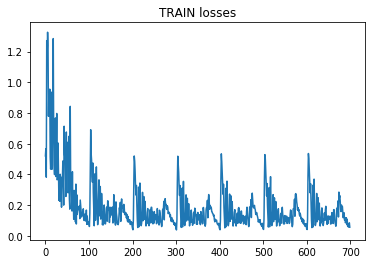

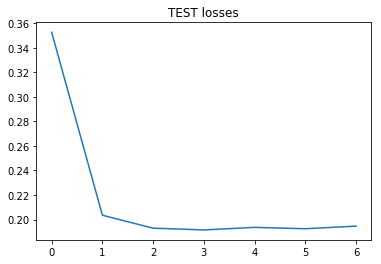

input and target sent to CUDA
Train Epoch: 2 [0/997 (0%)]	Loss: 0.046808
Train Epoch: 2 [10/997 (1%)]	Loss: 0.041776
Train Epoch: 2 [20/997 (2%)]	Loss: 0.111372
Train Epoch: 2 [30/997 (3%)]	Loss: 0.398673
Train Epoch: 2 [40/997 (4%)]	Loss: 0.554127
Train Epoch: 2 [50/997 (5%)]	Loss: 0.486398
Train Epoch: 2 [60/997 (6%)]	Loss: 0.422419
Train Epoch: 2 [70/997 (7%)]	Loss: 0.338737
Train Epoch: 2 [80/997 (8%)]	Loss: 0.268588
Train Epoch: 2 [90/997 (9%)]	Loss: 0.358855
Train Epoch: 2 [100/997 (10%)]	Loss: 0.185204
Train Epoch: 2 [110/997 (11%)]	Loss: 0.099064
Train Epoch: 2 [120/997 (12%)]	Loss: 0.053698
Train Epoch: 2 [130/997 (13%)]	Loss: 0.093940
Train Epoch: 2 [140/997 (14%)]	Loss: 0.311855
Train Epoch: 2 [150/997 (15%)]	Loss: 0.057570
Train Epoch: 2 [160/997 (16%)]	Loss: 0.249835
Train Epoch: 2 [170/997 (17%)]	Loss: 0.352981
Train Epoch: 2 [180/997 (18%)]	Loss: 0.202833
Train Epoch: 2 [190/997 (19%)]	Loss: 0.077381
Train Epoch: 2 [200/997 (20%)]	Loss: 0.064421
Train Epoch: 2 [210/997 (

o tensor([0.1739, 0.1600, 0.1272,  ..., 0.1896, 0.2651, 0.2016], device='cuda:0')
t tensor([0.2856, 0.2856, 0.2854,  ..., 0.8735, 0.8735, 0.8735], device='cuda:0')
-----------------------
correct 0
--------------------------
o tensor([0.1724, 0.1603, 0.1262,  ..., 0.1891, 0.2643, 0.1998], device='cuda:0')
t tensor([0.1827, 0.1823, 0.1809,  ..., 0.9637, 0.9637, 0.9637], device='cuda:0')
-----------------------
correct 0
--------------------------
o tensor([0.1786, 0.1604, 0.1267,  ..., 0.1889, 0.2592, 0.1971], device='cuda:0')
t tensor([0.3747, 0.3743, 0.3730,  ..., 0.6949, 0.6949, 0.6949], device='cuda:0')
-----------------------
correct 0
--------------------------
o tensor([0.1744, 0.1601, 0.1264,  ..., 0.1891, 0.2660, 0.1992], device='cuda:0')
t tensor([0.2302, 0.2302, 0.2301,  ..., 0.6374, 0.6371, 0.6370], device='cuda:0')
-----------------------
correct 0
--------------------------
o tensor([0.1678, 0.1607, 0.1254,  ..., 0.1892, 0.2613, 0.1982], device='cuda:0')
t tensor([0.2914, 

o tensor([0.1796, 0.1602, 0.1274,  ..., 0.1896, 0.2608, 0.2021], device='cuda:0')
t tensor([0.6500, 0.6501, 0.6502,  ..., 0.7238, 0.7240, 0.7240], device='cuda:0')
-----------------------
correct 0
--------------------------
o tensor([0.1520, 0.1557, 0.1898,  ..., 0.2928, 0.2899, 0.3208], device='cuda:0')
t tensor([0.2068, 0.2069, 0.2069,  ..., 0.8895, 0.8895, 0.8894], device='cuda:0')
-----------------------
correct 0
--------------------------
o tensor([0.1718, 0.1602, 0.1271,  ..., 0.1903, 0.2561, 0.2024], device='cuda:0')
t tensor([0.0011, 0.0011, 0.0011,  ..., 0.9777, 0.9777, 0.9777], device='cuda:0')
-----------------------
correct 0
--------------------------
o tensor([0.1667, 0.1605, 0.1253,  ..., 0.1886, 0.2406, 0.1936], device='cuda:0')
t tensor([0.0587, 0.0587, 0.0587,  ..., 0.9461, 0.9463, 0.9464], device='cuda:0')
-----------------------
correct 0
--------------------------
o tensor([0.1733, 0.1610, 0.1246,  ..., 0.1882, 0.2418, 0.1913], device='cuda:0')
t tensor([0.1505, 

correct 0
--------------------------
o tensor([0.1811, 0.1573, 0.1628,  ..., 0.2196, 0.2673, 0.2513], device='cuda:0')
t tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
-----------------------
correct 0
--------------------------
o tensor([0.1695, 0.1614, 0.1602,  ..., 0.2263, 0.2245, 0.2190], device='cuda:0')
t tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
-----------------------
correct 0
--------------------------
o tensor([0.1737, 0.1589, 0.1499,  ..., 0.2146, 0.2590, 0.2364], device='cuda:0')
t tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
-----------------------
correct 0
--------------------------
o tensor([0.1617, 0.1601, 0.1791,  ..., 0.2724, 0.2397, 0.2545], device='cuda:0')
t tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
-----------------------
correct 0
--------------------------
o tensor([0.1594, 0.1585, 0.1422,  ..., 0.2071, 0.2458, 0.2253], device='cuda:0')
t tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
-------------------

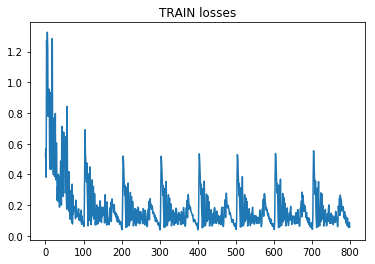

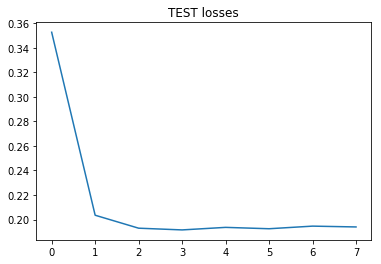

input and target sent to CUDA
Train Epoch: 3 [0/997 (0%)]	Loss: 0.047355
Train Epoch: 3 [10/997 (1%)]	Loss: 0.042477
Train Epoch: 3 [20/997 (2%)]	Loss: 0.111148
Train Epoch: 3 [30/997 (3%)]	Loss: 0.411402
Train Epoch: 3 [40/997 (4%)]	Loss: 0.524188
Train Epoch: 3 [50/997 (5%)]	Loss: 0.476661
Train Epoch: 3 [60/997 (6%)]	Loss: 0.484674
Train Epoch: 3 [70/997 (7%)]	Loss: 0.326203
Train Epoch: 3 [80/997 (8%)]	Loss: 0.288811
Train Epoch: 3 [90/997 (9%)]	Loss: 0.310285
Train Epoch: 3 [100/997 (10%)]	Loss: 0.226459
Train Epoch: 3 [110/997 (11%)]	Loss: 0.097029
Train Epoch: 3 [120/997 (12%)]	Loss: 0.051276
Train Epoch: 3 [130/997 (13%)]	Loss: 0.091516
Train Epoch: 3 [140/997 (14%)]	Loss: 0.384715
Train Epoch: 3 [150/997 (15%)]	Loss: 0.056904
Train Epoch: 3 [160/997 (16%)]	Loss: 0.221418
Train Epoch: 3 [170/997 (17%)]	Loss: 0.375565
Train Epoch: 3 [180/997 (18%)]	Loss: 0.229129
Train Epoch: 3 [190/997 (19%)]	Loss: 0.078448
Train Epoch: 3 [200/997 (20%)]	Loss: 0.064010
Train Epoch: 3 [210/997 (

o tensor([0.1603, 0.1481, 0.1420,  ..., 0.1913, 0.2060, 0.1986], device='cuda:0')
t tensor([0.3747, 0.3743, 0.3730,  ..., 0.6949, 0.6949, 0.6949], device='cuda:0')
-----------------------
correct 0
--------------------------
o tensor([0.1596, 0.1474, 0.1421,  ..., 0.1911, 0.2058, 0.1984], device='cuda:0')
t tensor([0.2302, 0.2302, 0.2301,  ..., 0.6374, 0.6371, 0.6370], device='cuda:0')
-----------------------
correct 0
--------------------------
o tensor([0.1518, 0.1443, 0.1415,  ..., 0.1886, 0.2027, 0.1936], device='cuda:0')
t tensor([0.2914, 0.2912, 0.2906,  ..., 0.3812, 0.3812, 0.3811], device='cuda:0')
-----------------------
correct 0
--------------------------
o tensor([0.1608, 0.1477, 0.1422,  ..., 0.1915, 0.2057, 0.1990], device='cuda:0')
t tensor([0.8507, 0.8507, 0.8507,  ..., 0.1821, 0.1822, 0.1823], device='cuda:0')
-----------------------
correct 0
--------------------------
o tensor([0.1590, 0.1488, 0.1420,  ..., 0.1927, 0.2095, 0.2005], device='cuda:0')
t tensor([0.9335, 

t tensor([0.6500, 0.6501, 0.6502,  ..., 0.7238, 0.7240, 0.7240], device='cuda:0')
-----------------------
correct 0
--------------------------
o tensor([0.1803, 0.1877, 0.1708,  ..., 0.3037, 0.2865, 0.3132], device='cuda:0')
t tensor([0.2068, 0.2069, 0.2069,  ..., 0.8895, 0.8895, 0.8894], device='cuda:0')
-----------------------
correct 0
--------------------------
o tensor([0.1578, 0.1449, 0.1425,  ..., 0.1885, 0.2022, 0.1939], device='cuda:0')
t tensor([0.0011, 0.0011, 0.0011,  ..., 0.9777, 0.9777, 0.9777], device='cuda:0')
-----------------------
correct 0
--------------------------
o tensor([0.1413, 0.1443, 0.1414,  ..., 0.1870, 0.2000, 0.1905], device='cuda:0')
t tensor([0.0587, 0.0587, 0.0587,  ..., 0.9461, 0.9463, 0.9464], device='cuda:0')
-----------------------
correct 0
--------------------------
o tensor([0.1493, 0.1428, 0.1416,  ..., 0.1871, 0.2000, 0.1898], device='cuda:0')
t tensor([0.1505, 0.1516, 0.1547,  ..., 0.3629, 0.3629, 0.3630], device='cuda:0')
------------------

t tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
-----------------------
correct 0
--------------------------
o tensor([0.1766, 0.1481, 0.1661,  ..., 0.2287, 0.2263, 0.2358], device='cuda:0')
t tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
-----------------------
correct 0
--------------------------
o tensor([0.1730, 0.1631, 0.1529,  ..., 0.2352, 0.2447, 0.2368], device='cuda:0')
t tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
-----------------------
correct 0
--------------------------
o tensor([0.1756, 0.1563, 0.1737,  ..., 0.2665, 0.2435, 0.2637], device='cuda:0')
t tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
-----------------------
correct 0
--------------------------
o tensor([0.1506, 0.1601, 0.1469,  ..., 0.2037, 0.2226, 0.2089], device='cuda:0')
t tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
-----------------------
[0.3525697973107502, 0.20350569114462663, 0.19294637319264762, tensor(0.1915, device='cuda:0'), tensor(0.1936, dev

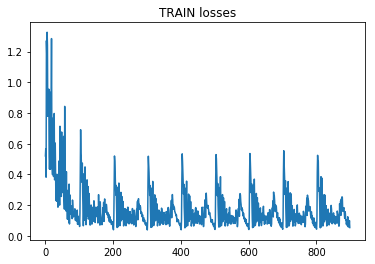

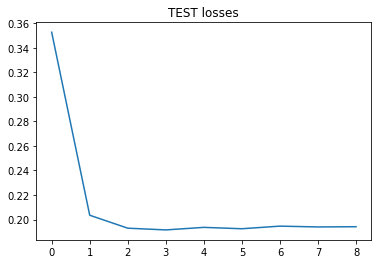

DONE


In [225]:
# CE E IN JOS DE AICI ERA TESTARE MAI VECHE, O PASTREZ JUST IN CASE

for epoch in range(1, n_epochs + 1):
    mask = train(epoch)
    test()  
#     split_audios_epoch(epoch, mask)
    
    plt.plot(train_losses)
    plt.title('TRAIN losses')
    plt.show()
    
    plt.plot(test_losses)
    plt.title('TEST losses')
    plt.show()

print("DONE")
# print(len(mask))

In [222]:
def train(epoch):
    mask = []
    network.train()
    
    # input is an AF, target is the mask for the PF of the current AF
    for index, (input, target) in enumerate(train_set.items()):
        
        assert(input.shape == (4, 1, 513, 11))
        assert(target.shape == (513, 11))

        target_view = target.view(-1, target.shape[0] * target.shape[1])
        
        # if cuda is available, send (input, target) to gpu
        if torch.cuda.is_available():
            input, target_view = input.cuda(), target_view.cuda()
            if index == 0:
                print("input and target sent to CUDA")

        optimizer.zero_grad()
        
        # 1. forward propagation
        output = network(input)
        
        # 2. loss calculation
        loss = loss_function(output[len(output)-1], target_view[0])       
        
        # 3. backward propagation
        loss.backward() 
        
        # 4. weight optimization
        optimizer.step()
            
        
        current_mask = output[len(output)-1].view(target.shape[0], target.shape[1])
        mask.append(output[len(output)-1])

        if index % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, index, len(train_set),
            100. * index / len(train_set), loss.item()))
            train_losses.append(loss.item())
            train_counter.append(
            (index) + ((epoch-1)*len(train_set.items())))
#             torch.save(network.state_dict(), './results/model.pth')
#             torch.save(optimizer.state_dict(), './results/optimizer.pth')

    return mask

In [223]:
def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for index, (input, target) in enumerate(test_set.items()):
            
            # if cuda is available, send (input, target) to gpu
            target_view = target.view(-1, target.shape[0] * target.shape[1])
            if torch.cuda.is_available():
                input, target_view = input.cuda(), target_view.cuda()
                if index == 0:
                    print("input and target sent to CUDA")
            
            output = network(input)
            
            test_loss += loss_function(output[len(output)-1], target_view[0])
            
            correct += (int)(torch.eq(output[len(output)-1], target_view[0]).sum())
            
#             print("test loss",test_loss)
            if index % 100 == 0:
                print("correct",correct)
                print("--------------------------")
                print("o",output[len(output)-1])
                print("t",target_view[0])
                print("-----------------------")

#             break
            
    test_loss /= len(test_set)
    test_losses.append(test_loss)
    print(test_losses)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_set),
    100. * correct / len(test_set)))